In [74]:
import pandas as pd
import numpy as np

# Custom functions
from my_functions import *

### Import data

In [75]:
# Box Office Mojo list
df_mojo = pd.read_csv('bk_mojo.csv', dtype = object)
df_mojo.head(2)

,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,Avatar,"$2,847,246,203","$760,507,625",26.7%,"$2,086,738,578",73.3%,2009
1,Avengers: Endgame,"$2,797,501,328","$858,373,000",30.7%,"$1,939,128,328",69.3%,2019


In [76]:
# Rotten Tomatoes
df_rt = pd.concat([pd.read_csv('Rotten Tomatoes/bk_rt_1_raw.csv', dtype = object)
                   , pd.read_csv('Rotten Tomatoes/bk_rt_2_raw.csv', dtype = object)
                   , pd.read_csv('Rotten Tomatoes/bk_rt_3_raw.csv', dtype = object)
                   , pd.read_csv('Rotten Tomatoes/bk_rt_4_raw.csv', dtype = object)
                   , pd.read_csv('Rotten Tomatoes/bk_rt_5_raw.csv', dtype = object)])
print(f'{len(df_rt)} rows of data loaded for {len(df_rt.mojo_name.unique())} films')
print(f'Therefore, {len(df_mojo) - len(df_rt.mojo_name.unique())} films were not found by the WebCrawler')
df_rt.head(2)

16189 rows of data loaded for 886 films
Therefore, 114 films were not found by the WebCrawler


,review,mojo_name,mojo_year,rt_name,genre,release_year,stream_year,critical_consensus,description
0,Five hundred million dollars [wasted].,Avatar,2009,Avatar - Movie Reviews,"Action , Fantasy , Adventure , Sci-Fi",2009,2016,It might be more impressive on a technical lev...,On the lush alien world of Pandora live the Na...
1,"Rewatching it with fresh eyes 10 years later, ...",Avatar,2009,Avatar - Movie Reviews,"Action , Fantasy , Adventure , Sci-Fi",2009,2016,It might be more impressive on a technical lev...,On the lush alien world of Pandora live the Na...


In [77]:
# Remove Rotten Tomato records without reviews
df_rt_clean = df_rt.loc[~((df_rt['review'] == 'no reviews found')
                          |
                          (df_rt['review'] == 'misc error')
                          |
                          (df_rt['review'] == '')
                         )
                        ,:].dropna()
print(f'{len(df_rt) - len(df_rt_clean)} rows of removed')

443 rows of removed


In [78]:
# Film has no release year and stream year doesn't align to year from the Box Office Mojo data.
df_rt_clean[df_rt_clean.mojo_name == 'The Avengers'].head()

,review,mojo_name,mojo_year,rt_name,genre,release_year,stream_year,critical_consensus,description
120,Very terrible.,The Avengers,2012,The Avengers - Movie Reviews,Adventure,In Theaters:,2008,"A TV spinoff that lacks enough energy to spin,...",A charismatic evil genius named Sir August de ...
121,The movie lets [Fiennes and Thurman] down with...,The Avengers,2012,The Avengers - Movie Reviews,Adventure,In Theaters:,2008,"A TV spinoff that lacks enough energy to spin,...",A charismatic evil genius named Sir August de ...
122,"The new Avengers is dismal in dispiriting, dre...",The Avengers,2012,The Avengers - Movie Reviews,Adventure,In Theaters:,2008,"A TV spinoff that lacks enough energy to spin,...",A charismatic evil genius named Sir August de ...
123,Some bad movies are bold outrages; many others...,The Avengers,2012,The Avengers - Movie Reviews,Adventure,In Theaters:,2008,"A TV spinoff that lacks enough energy to spin,...",A charismatic evil genius named Sir August de ...
124,"This Avengers film is so horrendously, painful...",The Avengers,2012,The Avengers - Movie Reviews,Adventure,In Theaters:,2008,"A TV spinoff that lacks enough energy to spin,...",A charismatic evil genius named Sir August de ...


In [79]:
# Group records into a single line per film (reviews become a list of reviews)
df_rt_clean = rev_group_list(df_rt_clean, 'review', 'mojo_name')

print('Number of films grouped: ', len(df_rt_clean))

# Remove records where release year != mojo_year
df_rt_clean = df_rt_clean[df_rt_clean['mojo_year'] == df_rt_clean['release_year']]

print('Number of films remaining: ', len(df_rt_clean))

df_rt_clean.head()

Number of films grouped:  882
Number of films remaining:  672


,review,mojo_name,mojo_year,rt_name,genre,release_year,stream_year,critical_consensus,description
1112,[ ‘Here are beauties that pierce like swords o...,The Lord of the Rings: The Fellowship of the Ring,2001,The Lord of the Rings: The Fellowship of the R...,"Fantasy , Adventure",2001,2011,"Full of eye-popping special effects, and featu...",The future of civilization rests in the fate o...
391,"[""...for me to consider Captain America: Civil...",Captain America: Civil War,2016,Captain America: Civil War - Movie Reviews,"Action , Fantasy , Adventure",2016,2016,Captain America: Civil War begins the next wav...,Political pressure mounts to install a system ...
659,"[""21 Jump Street"" might be yet another product...",21 Jump Street,2012,21 Jump Street - Movie Reviews,"Action , Comedy",2012,2014,"A smart, affectionate satire of '80s nostalgia...",When cops Schmidt (Jonah Hill) and Jenko (Chan...
474,"[""300: Rise of an Empire"" gets a lot of mileag...",300: Rise of an Empire,2014,300: Rise of an Empire - Movie Reviews,"Action , Adventure , Drama",2014,2015,It's bound to hit some viewers as an empty exe...,While King Leonidas and his 300 Spartans have ...
322,"[""A Dog's Purpose"" left me cherishing my borde...",A Dog's Purpose,2017,A Dog's Purpose - Movie Reviews,"Comedy , Fantasy , Drama",2017,2017,A Dog's Purpose offers an awkward blend of sug...,A devoted dog (Josh Gad) discovers the meaning...


### Merge DataFrames

In [80]:
# Merge Rotten Tomatoes data
df_merge = df_mojo.merge(df_rt_clean
                         , how='left'
                         , left_on = ['Title', 'Year']
                         , right_on = ['mojo_name', 'mojo_year'])

# Filter to columns that we will need
df_merge = df_merge.loc[:,['Title'
                          , 'Year'
                          , 'Worldwide Lifetime Gross'
                          , 'Domestic %'
                          , 'genre'
                          , 'description'
                          , 'critical_consensus'
                          , 'review']]

# Rename columns
df_merge.columns = ['title'
                  , 'year'
                  , 'worldwide_gross'
                  , 'usa_percent'
                  , 'genre'
                  , 'movie_description'
                  , 'critical_consensus'
                  , 'review']

# Remove any empty rows remaining
df_merge = df_merge.dropna()

print('Number of records remaining: ', len(df_merge))

Number of records remaining:  672


### Clean up DataFrame

In [81]:
# freq_words_chart(df_merge['review'].apply(lambda x: '| '.join(x)), 50, 'Reviews')

In [82]:
# freq_words_chart(df_merge['movie_description'], 50, 'Description')

In [83]:
# Convert numbers to floats
df_merge['worldwide_gross'] = df_merge['worldwide_gross'].apply(lambda x: re.sub("[^0-9]", "",x)).astype(float)
df_merge['usa_percent'] = df_merge['usa_percent'].apply(lambda x: usa_pc(x))

# Clean text
# 1) Remove non-letters
# 2) Remove stop words for descriptions and reviews
# 3) Lemmatize text for descriptions and reviews
df_merge['genre'] = df_merge['genre'].apply(lambda x: re.sub(" ,","", x).lower())   
df_merge['movie_description'] = df_merge['movie_description'].apply(lambda x: clean_text(x, True)) 
df_merge['critical_consensus'] = df_merge['critical_consensus'].apply(lambda x: clean_text(x, True))
df_merge['review_list'] = df_merge['review'].apply(lambda x: clean_text_list(x, True)) 
df_merge['reviews'] = df_merge['review_list'].apply(lambda x: ', '.join(x))

df_merge.head(3)

,title,year,worldwide_gross,usa_percent,genre,movie_description,critical_consensus,review,review_list,reviews
0,Avatar,2009,2.847246e+09,0.267,action fantasy adventure sci-fi,lush alien world pandora live navi beings appe...,might impressive technical level piece storyte...,[Avatar is a joyous celebration of story craft...,[avatar joyous celebration story craft visual ...,avatar joyous celebration story craft visual p...
1,Avengers: Endgame,2019,2.797501e+09,0.307,action fantasy adventure sci-fi,adrift space food water tony stark sends messa...,exciting entertaining emotionally impactful av...,"[...A wonderful, rousing payoff in the context...",[wonderful rousing payoff context big battle w...,wonderful rousing payoff context big battle wi...
2,Titanic,1997,2.201647e+09,0.300,history drama romance,james camerons titanic epic action packed roma...,mostly unqualified triumph james cameron offer...,"[""Titanic"" still amazes as the kind of massive...",[titanic still amazes kind massive build destr...,titanic still amazes kind massive build destro...


### Exploratory Data Analysis

#### Evaluate most frequent words
The removal of the stop words has reduced the skew in the distribution of frequency of words.

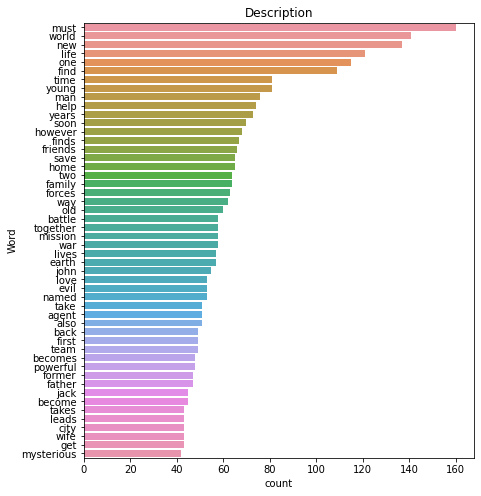

In [84]:
freq_words_chart(df_merge['movie_description'], 50, 'Description')

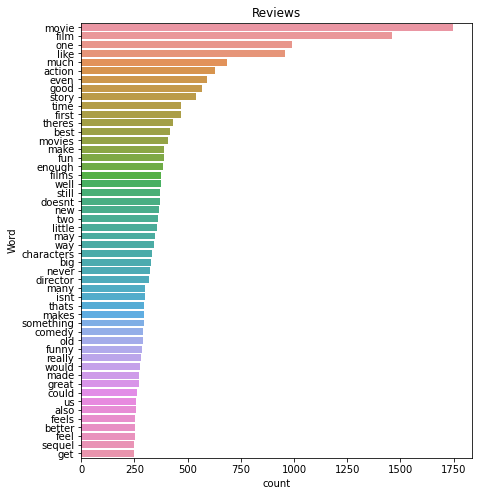

In [85]:
figsize = (1,7)
freq_words_chart(df_merge['reviews'], 50, 'Reviews')

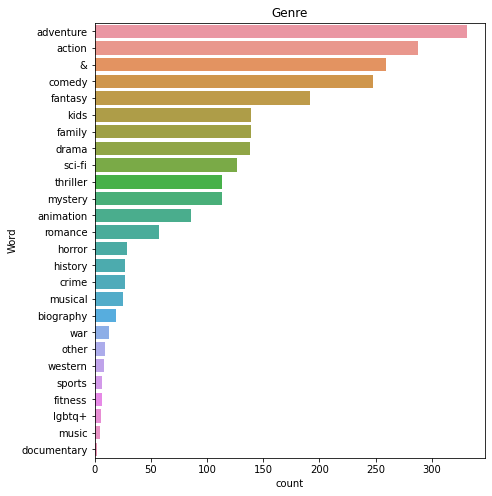

In [86]:
freq_words_chart(df_merge['genre'], 50, 'Genre')

In [87]:
desc_stats = round(df_merge.describe(),2)
desc_stats['worldwide_gross'] = desc_stats['worldwide_gross'].astype(np.int64) 
desc_stats

,worldwide_gross,usa_percent
count,672,672.00
mean,430943846,0.39
std,317680755,0.14
min,173469516,0.00
25%,222361331,0.30
50%,320585814,0.39
75%,520953571,0.49
max,2847246203,0.87


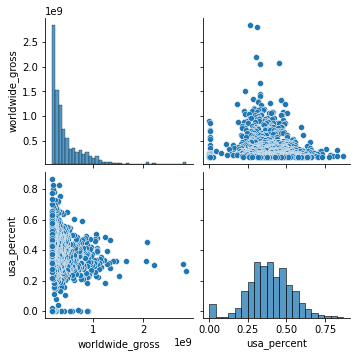

In [88]:
# plot the pair plot of salary, balance and age in data dataframe.
sns.pairplot(data = df_merge, vars=list(desc_stats.columns))
plt.show()

Text(0.5, 1.0, 'Description word count distribution')

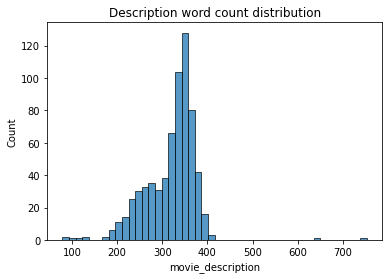

In [89]:
des_len = df_merge['movie_description'].apply(lambda x: len(x))
sns.histplot(des_len)
plt.title('Description word count distribution')

Text(0.5, 1.0, 'Review word count distribution')

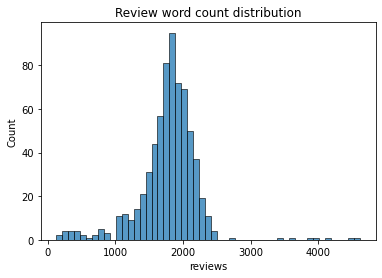

In [90]:
rev_len = df_merge['reviews'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count distribution')

## Sentiment Analysis
#### Labelling the reviews 

In [93]:
# Determine Sentiment of Reviews; see (Hutto, n.d.)
df_merge['sentiment'] = df_merge['review'].apply(lambda x: sid_analyser(x, True))
df_merge['sentiment_all'] = df_merge['review'].apply(lambda x: sid_analyser(x, False))

# Split overall scores into seperate columns for plotting
df_merge['sentiment_pos'] = df_merge['sentiment'].apply(lambda x: x['pos'])
df_merge['sentiment_neg'] = df_merge['sentiment'].apply(lambda x: x['neg'])
df_merge['sentiment_neu'] = df_merge['sentiment'].apply(lambda x: x['neu'])
df_merge['sentiment_comp'] = df_merge['sentiment'].apply(lambda x: x['compound'])

# Apply overall sentiment classification label
df_merge['sentiment_overall'] = df_merge['sentiment'].apply(lambda x: sentiment_overall(x['compound']))

df_merge.head(2)

,title,year,worldwide_gross,usa_percent,genre,movie_description,critical_consensus,review,review_list,reviews,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,Avatar,2009,2.847246e+09,0.267,action fantasy adventure sci-fi,lush alien world pandora live navi beings appe...,might impressive technical level piece storyte...,[Avatar is a joyous celebration of story craft...,[avatar joyous celebration story craft visual ...,avatar joyous celebration story craft visual p...,"{'neg': 0.039, 'neu': 0.784, 'pos': 0.177, 'co...","[{'neg': 0.046, 'neu': 0.814, 'pos': 0.14, 'co...",0.177,0.039,0.784,0.9968,positive
1,Avengers: Endgame,2019,2.797501e+09,0.307,action fantasy adventure sci-fi,adrift space food water tony stark sends messa...,exciting entertaining emotionally impactful av...,"[...A wonderful, rousing payoff in the context...",[wonderful rousing payoff context big battle w...,wonderful rousing payoff context big battle wi...,"{'neg': 0.044, 'neu': 0.822, 'pos': 0.134, 'co...","[{'neg': 0.118, 'neu': 0.588, 'pos': 0.294, 'c...",0.134,0.044,0.822,0.9910,positive


In [94]:
# note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    592
negative     79
neutral       1
Name: sentiment_overall, dtype: int64

Text(0.5, 1.0, 'Compound Sentiment')

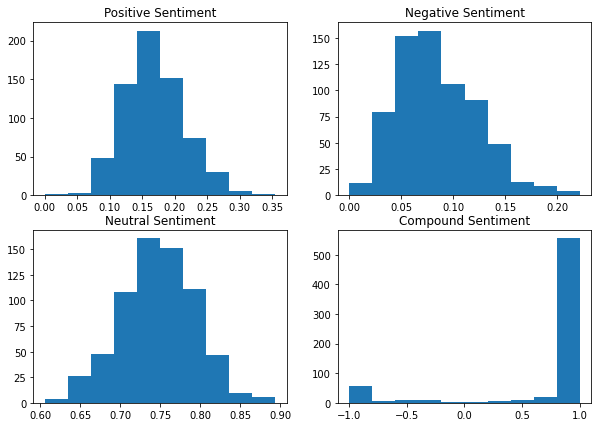

In [95]:
fig, axs = plt.subplots(2, 2, figsize = (10,7))

# Plot the distribution of sentiment
axs[0,0].hist(df_merge['sentiment_pos'])
axs[0,0].set_title("Positive Sentiment")
axs[0,1].hist(df_merge['sentiment_neg'])
axs[0,1].set_title("Negative Sentiment")
axs[1,0].hist(df_merge['sentiment_neu'])
axs[1,0].set_title("Neutral Sentiment")
axs[1,1].hist(df_merge['sentiment_comp'])
axs[1,1].set_title("Compound Sentiment")

**What is the neutral review?**

It looks like the reviews are balanced between positive and negative. 

As this is the only film that VADER has classified as neutral, we will remove it from the dataset.

In [96]:
# What is the neutral review?
print('Film: ', df_merge[df_merge['sentiment_overall'] == 'neutral']['title'].values)

Film:  ['The Matrix Revolutions']


In [97]:
# How are the reviews scored individually?
df_merge.head()

sent = []
for i in list(df_merge[df_merge['sentiment_overall'] == 'neutral']['sentiment_all'])[0]:
    sent.append([i['compound'], sentiment_overall(np.mean(i['compound']))])
    
pd.DataFrame(sent)[1].value_counts()

negative    7
positive    7
neutral     5
Name: 1, dtype: int64

In [98]:
# Remove film
df_merge = df_merge[df_merge.title != 'The Matrix Revolutions']

In [99]:
# Save dataframe to CSV
df_merge.to_csv('bk_data_merged.csv', index = False)